In [8]:
# ============================
# Classificação de Imagens - CIFAR-10 com CNN
# ============================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [9]:
# ----------------------------
# 1. Carregar e preparar os dados
# ----------------------------
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_names = ['avião','carro','pássaro','gato','cervo',
               'cachorro','sapo','cavalo','navio','caminhão']

# Normalizar
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encoding
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Dividir treino/validação de forma dinâmica (80% treino / 20% validação)
x_train, x_val, y_train_cat, y_val = train_test_split(
    x_train, y_train_cat, test_size=0.2, random_state=42
)

print("Shape treino:", x_train.shape, y_train_cat.shape)
print("Shape validação:", x_val.shape, y_val.shape)
print("Shape teste:", x_test.shape, y_test_cat.shape)

Shape treino: (40000, 32, 32, 3) (40000, 10)
Shape validação: (10000, 32, 32, 3) (10000, 10)
Shape teste: (10000, 32, 32, 3) (10000, 10)


In [10]:
# ----------------------------
# 2. Construção do modelo CNN
# ----------------------------
modelo = Sequential()

# Bloco 1
modelo.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
modelo.add(BatchNormalization())
modelo.add(Conv2D(32, (3, 3), activation='relu'))
modelo.add(MaxPooling2D(pool_size=(2, 2)))
modelo.add(Dropout(0.25))

# Bloco 2
modelo.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
modelo.add(BatchNormalization())
modelo.add(Conv2D(64, (3, 3), activation='relu'))
modelo.add(MaxPooling2D(pool_size=(2, 2)))
modelo.add(Dropout(0.25))

# Bloco 3
modelo.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
modelo.add(BatchNormalization())
modelo.add(Conv2D(128, (3, 3), activation='relu'))
modelo.add(MaxPooling2D(pool_size=(2, 2)))
modelo.add(Dropout(0.4))

# Classificador final
modelo.add(Flatten())
modelo.add(Dense(256, activation='relu'))
modelo.add(Dropout(0.5))
modelo.add(Dense(10, activation='softmax'))

modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelo.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,802 (1.61 MB)

 Trainable params: 421,354 (1.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
# ----------------------------
# 3. Callbacks
# ----------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("best_cifar10_cnn.h5", save_best_only=True)
]

In [12]:
# ----------------------------
# 4. Treinamento
# ----------------------------
history = modelo.fit(
    x_train, y_train_cat,
    batch_size=64,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2523 - loss: 2.1088

625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.2526 - loss: 2.1074 - val_accuracy: 0.4458 - val_loss: 1.5118
Epoch 2/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4754 - loss: 1.4374

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4755 - loss: 1.4372 - val_accuracy: 0.5887 - val_loss: 1.1288
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5782 - loss: 1.1965 - val_accuracy: 0.5880 - val_loss: 1.1729
Epoch 4/100
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6449 - loss: 1.0301

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6450 - loss: 1.0300 - val_accuracy: 0.6968 - val_loss: 0.8701
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6778 - loss: 0.9286 - val_accuracy: 0.6850 - val_loss: 0.8890
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7026 - loss: 0.8663 - val_accuracy: 0.6894 - val_loss: 0.8877
Epoch 7/100
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7240 - loss: 0.8050

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7240 - loss: 0.8050 - val_accuracy: 0.7340 - val_loss: 0.7622
Epoch 8/100
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7367 - loss: 0.7618

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7367 - loss: 0.7619 - val_accuracy: 0.7346 - val_loss: 0.7480
Epoch 9/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7553 - loss: 0.7246 - val_accuracy: 0.7009 - val_loss: 0.8776
Epoch 10/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7636 - loss: 0.6843

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7636 - loss: 0.6844 - val_accuracy: 0.7574 - val_loss: 0.7077
Epoch 11/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7762 - loss: 0.6598 - val_accuracy: 0.7290 - val_loss: 0.7835
Epoch 12/100
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7768 - loss: 0.6470

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7768 - loss: 0.6470 - val_accuracy: 0.7896 - val_loss: 0.6166
Epoch 13/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7891 - loss: 0.6143 - val_accuracy: 0.7696 - val_loss: 0.6647
Epoch 14/100
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7976 - loss: 0.5932

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7976 - loss: 0.5932 - val_accuracy: 0.7902 - val_loss: 0.6118
Epoch 15/100
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8043 - loss: 0.5810

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8043 - loss: 0.5811 - val_accuracy: 0.7967 - val_loss: 0.6049
Epoch 16/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7997 - loss: 0.5758 - val_accuracy: 0.7935 - val_loss: 0.6082
Epoch 17/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8113 - loss: 0.5458 - val_accuracy: 0.7988 - val_loss: 0.6073
Epoch 18/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8198 - loss: 0.5268 - val_accuracy: 0.7946 - val_loss: 0.6190
Epoch 19/100
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8175 - loss: 0.5228

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8175 - loss: 0.5228 - val_accuracy: 0.8211 - val_loss: 0.5426
Epoch 20/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8258 - loss: 0.5143 - val_accuracy: 0.7969 - val_loss: 0.5985
Epoch 21/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8290 - loss: 0.4981 - val_accuracy: 0.8110 - val_loss: 0.5768
Epoch 22/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8313 - loss: 0.4905 - val_accuracy: 0.7848 - val_loss: 0.6738
Epoch 23/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8385 - loss: 0.4715 - val_accuracy: 0.8190 - val_loss: 0.5600
Epoch 24/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8365 - loss: 0.4728 - val_accuracy: 0.8103 - val_loss: 0.5812
Epoch 25/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8447 - loss: 0.4563 - val_accuracy: 0.8057 - val_loss: 0.6025
Epoch 26/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8432 - loss: 0.4515 - val_accuracy:

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8485 - loss: 0.4356 - val_accuracy: 0.8199 - val_loss: 0.5368
Epoch 29/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8538 - loss: 0.4249 - val_accuracy: 0.7798 - val_loss: 0.7110
Epoch 30/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8534 - loss: 0.4246 - val_accuracy: 0.8139 - val_loss: 0.5761
Epoch 31/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8521 - loss: 0.4277 - val_accuracy: 0.8006 - val_loss: 0.6140
Epoch 32/100
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8619 - loss: 0.4057

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8619 - loss: 0.4058 - val_accuracy: 0.8309 - val_loss: 0.5268
Epoch 33/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8636 - loss: 0.3985 - val_accuracy: 0.8221 - val_loss: 0.5669
Epoch 34/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8625 - loss: 0.3994 - val_accuracy: 0.8204 - val_loss: 0.5681
Epoch 35/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8681 - loss: 0.3892 - val_accuracy: 0.8181 - val_loss: 0.5684
Epoch 36/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8679 - loss: 0.3801 - val_accuracy: 0.8171 - val_loss: 0.5831
Epoch 37/100
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8727 - loss: 0.3766

625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8727 - loss: 0.3767 - val_accuracy: 0.8368 - val_loss: 0.5157
Epoch 38/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8689 - loss: 0.3753 - val_accuracy: 0.8186 - val_loss: 0.5791
Epoch 39/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8761 - loss: 0.3658 - val_accuracy: 0.8298 - val_loss: 0.5267
Epoch 40/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8739 - loss: 0.3651 - val_accuracy: 0.8228 - val_loss: 0.5623
Epoch 41/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8753 - loss: 0.3676 - val_accuracy: 0.8363 - val_loss: 0.5237
Epoch 42/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8793 - loss: 0.3510 - val_accuracy: 0.8312 - val_loss: 0.5439
Epoch 43/100
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8802 - loss: 0.3450

625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8801 - loss: 0.3451 - val_accuracy: 0.8406 - val_loss: 0.5059
Epoch 44/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8795 - loss: 0.3490 - val_accuracy: 0.8228 - val_loss: 0.5511
Epoch 45/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8833 - loss: 0.3372 - val_accuracy: 0.8205 - val_loss: 0.5652
Epoch 46/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8816 - loss: 0.3391

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8816 - loss: 0.3391 - val_accuracy: 0.8433 - val_loss: 0.4999
Epoch 47/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8811 - loss: 0.3432 - val_accuracy: 0.8363 - val_loss: 0.5281
Epoch 48/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8868 - loss: 0.3346 - val_accuracy: 0.8143 - val_loss: 0.6170
Epoch 49/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8824 - loss: 0.3336 - val_accuracy: 0.8364 - val_loss: 0.5434
Epoch 50/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8869 - loss: 0.3260 - val_accuracy: 0.8371 - val_loss: 0.5420
Epoch 51/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8913 - loss: 0.3176 - val_accuracy: 0.8349 - val_loss: 0.5425
Epoch 52/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8910 - loss: 0.3206 - val_accuracy: 0.8392 - val_loss: 0.5317
Epoch 53/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8886 - loss: 0.3156 - val_accuracy:

Acurácia no teste: 0.8366
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

Classification Report:
              precision    recall  f1-score   support

       avião       0.83      0.85      0.84      1000
       carro       0.95      0.91      0.93      1000
     pássaro       0.86      0.69      0.77      1000
        gato       0.73      0.65      0.69      1000
       cervo       0.82      0.82      0.82      1000
    cachorro       0.74      0.81      0.77      1000
        sapo       0.79      0.93      0.86      1000
      cavalo       0.87      0.88      0.87      1000
       navio       0.90      0.90      0.90      1000
    caminhão       0.87      0.93      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



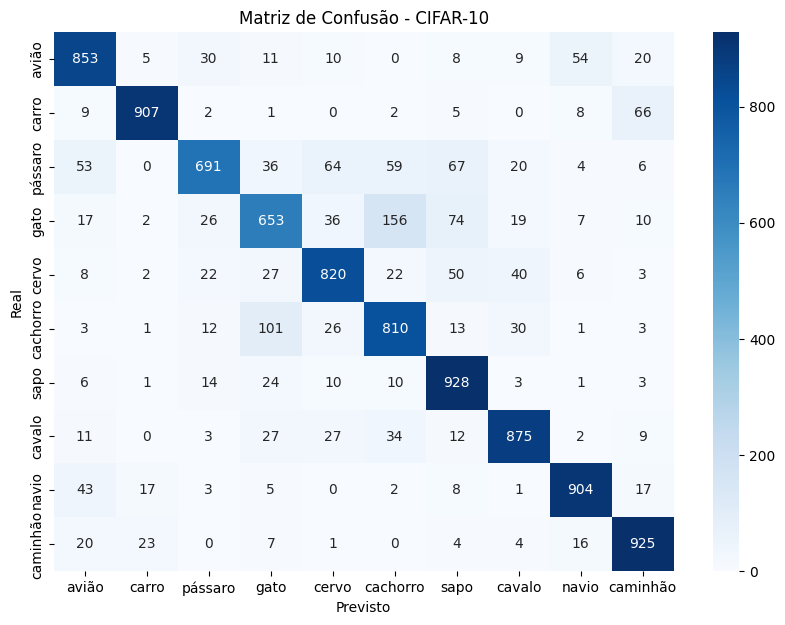

In [13]:
# ----------------------------
# 5. Avaliação no teste
# ----------------------------
test_loss, test_acc = modelo.evaluate(x_test, y_test_cat, verbose=0)
print(f"Acurácia no teste: {test_acc:.4f}")

# Predições
y_pred_proba = modelo.predict(x_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Relatório
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusão - CIFAR-10")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()


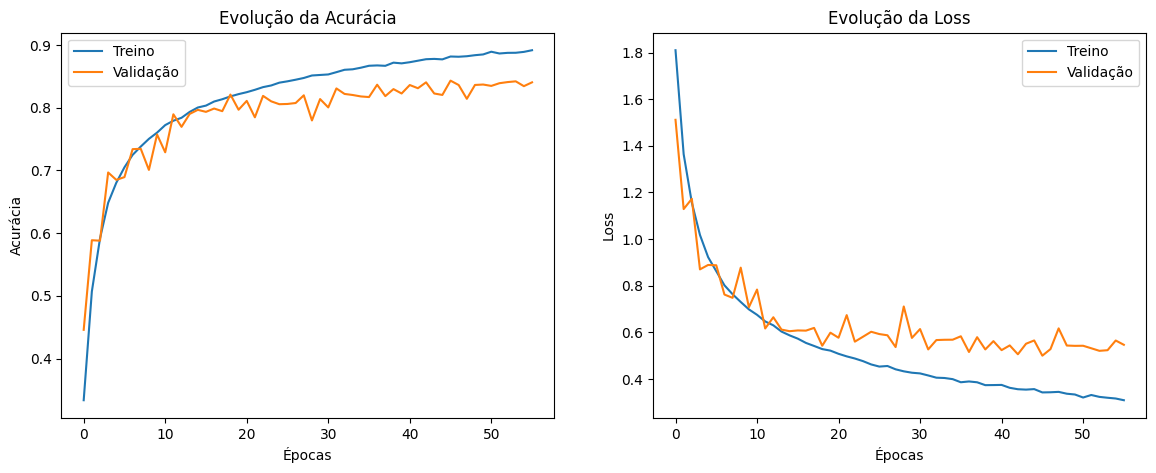

In [14]:
# ----------------------------
# 6. Curvas de treinamento
# ----------------------------
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title("Evolução da Acurácia")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title("Evolução da Loss")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

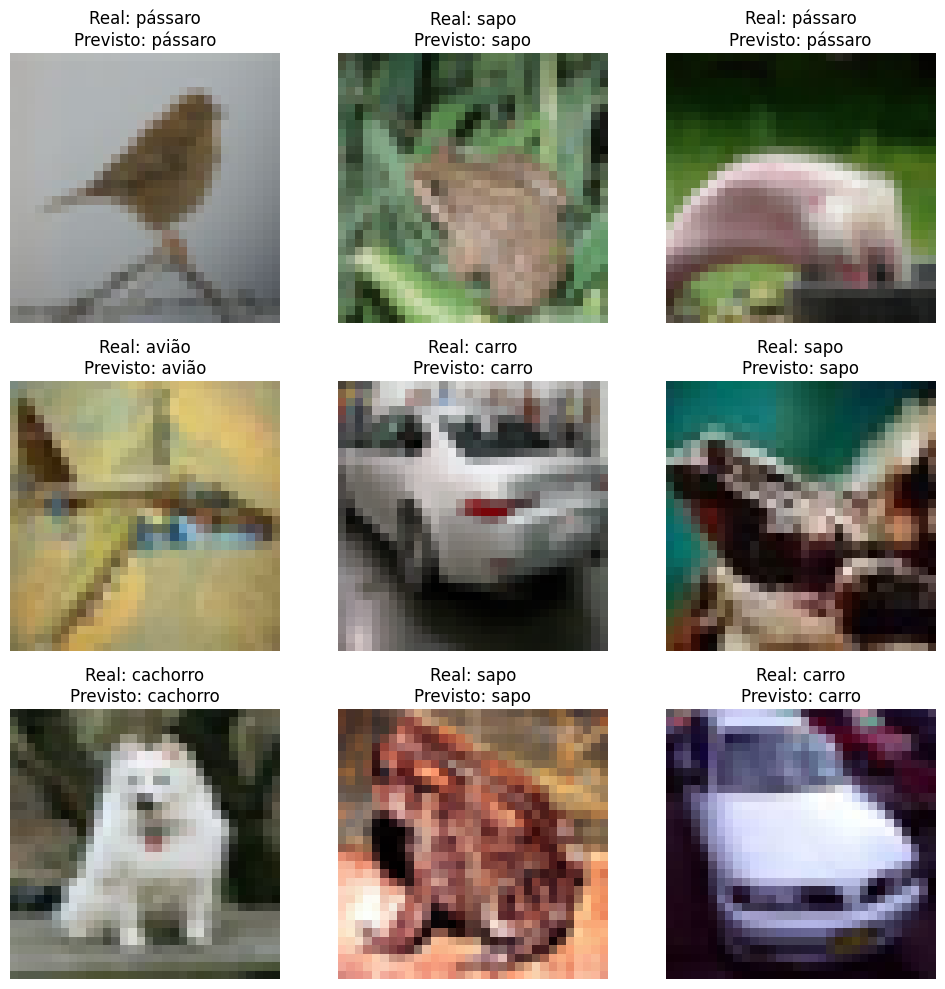

In [15]:
# ----------------------------
# 7. Visualização de predições
# ----------------------------
indices = np.random.choice(len(x_test), 9, replace=False)
plt.figure(figsize=(10,10))
for i, idx in enumerate(indices):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[idx])
    plt.axis("off")
    plt.title(f"Real: {class_names[y_true[idx]]}\nPrevisto: {class_names[y_pred[idx]]}")
plt.tight_layout()
plt.show()